# Analyzing a split MSTIS simulation

Included in this notebook:

* Opening split files and look at the data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import numpy as np

In [2]:
%%time
storage = paths.AnalysisStorage('mstis_data.nc')

CPU times: user 7.65 s, sys: 127 ms, total: 7.78 s
Wall time: 7.78 s


Analyze the rate with no snapshots present in the analyzed file

In [3]:
mstis = storage.networks.load(0)

In [4]:
mstis.hist_args['max_lambda'] = { 'bin_width' : 0.02, 'bin_range' : (0.0, 0.5) }
mstis.hist_args['pathlength'] = { 'bin_width' : 5, 'bin_range' : (0, 150) }

In [5]:
%%time
mstis.rate_matrix(storage.steps, force=True)

CPU times: user 4.87 s, sys: 245 ms, total: 5.12 s
Wall time: 4.96 s


,"{x|opA(x) in [0.0, 0.2]}","{x|opB(x) in [0.0, 0.2]}","{x|opC(x) in [0.0, 0.2]}"
"{x|opA(x) in [0.0, 0.2]}",NaN,0.00139595,0
"{x|opB(x) in [0.0, 0.2]}",0.00229702,NaN,0.0128833
"{x|opC(x) in [0.0, 0.2]}",0.000852395,0.00485865,NaN


### Move scheme analysis

In [6]:
scheme = storage.schemes[0]

In [7]:
scheme.move_summary(storage.steps)

Null moves for 1 cycles. Excluding null moves:
ms_outer_shooting ran 4.500% (expected 4.98%) of the cycles with acceptance 21/27 (77.78%)
repex ran 20.667% (expected 22.39%) of the cycles with acceptance 49/124 (39.52%)
shooting ran 47.333% (expected 44.78%) of the cycles with acceptance 207/284 (72.89%)
minus ran 2.500% (expected 2.99%) of the cycles with acceptance 11/15 (73.33%)
pathreversal ran 25.000% (expected 24.88%) of the cycles with acceptance 99/150 (66.00%)


### Replica move history tree

In [8]:
import openpathsampling.visualize as vis
reload(vis)
from IPython.display import SVG

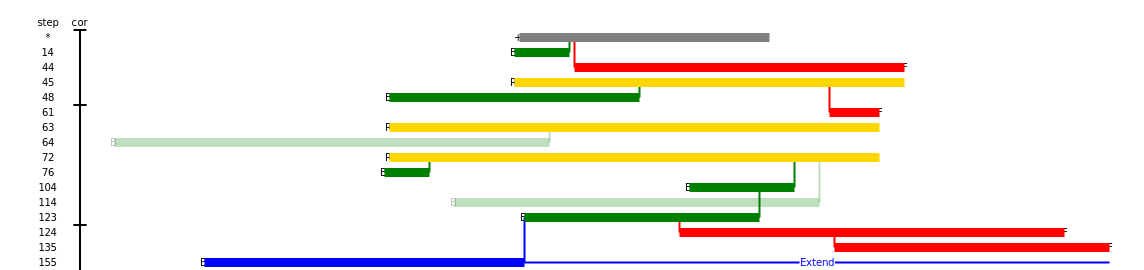

In [9]:
tree = vis.PathTree(
    storage.steps[0:200],
    vis.ReplicaEvolution(replica=2, accepted=False)
)

SVG(tree.svg())

In [10]:
decorrelated = tree.generator.decorrelated
print "We have " + str(len(decorrelated)) + " decorrelated trajectories."

We have 3 decorrelated trajectories.


### Visualizing trajectories

In [11]:
from toy_plot_helpers import ToyPlot
background = ToyPlot()
background.contour_range = np.arange(-1.5, 1.0, 0.1)
background.add_pes(storage.engines[0].pes)

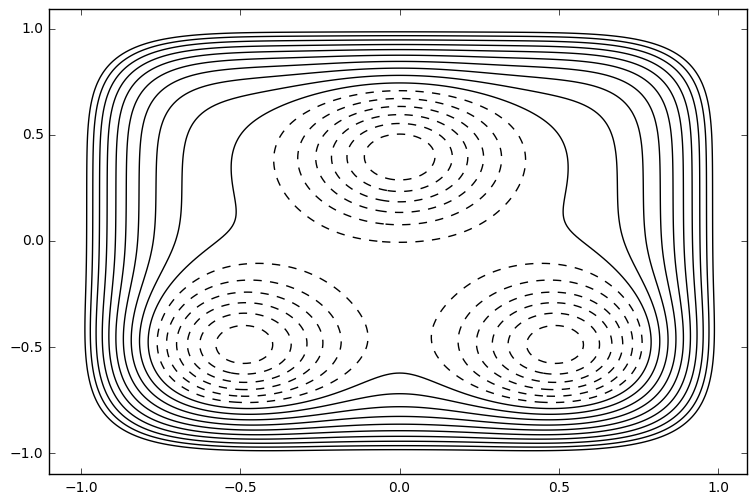

In [12]:
xval = paths.FunctionCV("xval", lambda snap : snap.xyz[0][0])
yval = paths.FunctionCV("yval", lambda snap : snap.xyz[0][1])
live_vis = paths.StepVisualizer2D(mstis, xval, yval, [-1.0, 1.0], [-1.0, 1.0])
live_vis.background = background.plot()

to make this work we need the actual snapshot coordinates! These are not
present in the data file anymore so we attach the traj as a fallback.
We are not using analysis storage since we do not cache anything.

In [14]:
storage.cvs

store.cvs[CollectiveVariable]

In [13]:
fallback = paths.Storage('mstis_traj.nc', 'r')

In [14]:
storage.fallback = fallback

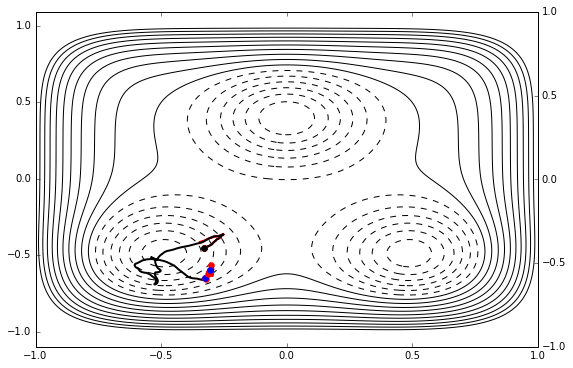

In [15]:
live_vis.draw_samples(list(tree.samples))